## Imports

In [1]:
import pandas as pd
import numpy as np

# from sklearn.experimental import enable_halving_search_cv

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate #, HalvingGridSearchCV, HalvingRandomSearchCV

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.svm import SVC

import seaborn as sns

In [2]:
# Function definitions
def title_apply(df, col):
    splitted = df[col].split(' ')

    mr = ['Mr.']
    miss = ['Miss.','Mrs.','Dona.']
    power = ['Master.','Rev.','Dr.','Mlle.','Ms.','Lady.','Sir.','Mme.','Don.','Jonkheer.','Countess.']
    millitary = ['Col.','Major.','Capt.']

    for i in splitted:
        if '.' in i:
            if i in mr:
                return 'Mr'
            
            elif i in miss:
                return 'Miss'
            
            elif i in power:
                return 'Power'
            
            elif i in millitary:
                return 'Millitary'

### Reading the data

In [3]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
gender_submission = pd.read_csv("gender_submission.csv")

df_full = pd.concat([df_train[df_test.columns],df_test]).reset_index(drop=True)

### Featuring Engineering with full data
- Transforming categorical to numeric

In [4]:
sex_dummies = pd.get_dummies(df_full['Sex'], prefix='Sex') # drop sex

embarked_dummies = pd.get_dummies(df_full['Embarked'], prefix='Emb')

- Fill age with mean value and fare

In [5]:
# Age
df_full['Age'] = df_full['Age'].round(0)
df_full['Age'] = df_full['Age'].fillna(round(df_full['Age'].median(),0))

# Fare
df_full['Fare'] = df_full['Fare'].fillna(0)

- Title

In [6]:
# Applying new title column
df_full['Title'] = df_full.apply(lambda x: title_apply(x, 'Name'), axis=1)

# Categorical to numerical
title_dummies = pd.get_dummies(df_full['Title'], prefix='Title')

#titles = list(set(titles))
#titles.remove('L.')
#titles

In [7]:
df_full['Title'].value_counts()

Mr           757
Miss         458
Power         87
Millitary      7
Name: Title, dtype: int64

- Total size of family

In [8]:
df_full['Total_Family_Size'] = df_full['SibSp'] + df_full['Parch'] + 1

df_full['Family_Fare'] = df_full['Fare'] / df_full['Total_Family_Size']

- Ticket feature

In [9]:
df_full['Ticket'] = df_full['Ticket'].str.replace('[/. ]','', regex=True)

In [10]:
def define_ticket_numbers(df, col):
    if sum(c.isdigit() for c in df[col]) == 7:
        return '7_D'
    
    elif sum(c.isdigit() for c in df[col]) == 6:
        return '6_D'
    
    elif sum(c.isdigit() for c in df[col]) == 5:
        return '5_D'
    
    elif sum(c.isdigit() for c in df[col]) == 4:
        return '4_D'
    
    else:
        return 'Some_D'
    

df_full['Ticket'] = df_full.apply(lambda x: define_ticket_numbers(x, 'Ticket'), axis=1)

In [11]:
df_full['Ticket'].value_counts()

6_D       629
5_D       372
4_D       230
Some_D     42
7_D        36
Name: Ticket, dtype: int64

In [12]:
ticket_dummies = pd.get_dummies(df_full['Ticket'], prefix='Ticket')

- Cabin Feature

In [13]:
df_full['Cabin'] = df_full['Cabin'].fillna('Z')
df_full['Cabin'] = df_full['Cabin'].str[0]

In [14]:
cabin_dummies = pd.get_dummies(df_full['Cabin'], prefix='Cabin')

# df_full['Cabin'] = pd.Categorical(df_full['Cabin'])
# df_full['Cabin_n'] = df_full['Cabin'].cat.codes

In [15]:
df_full = df_full.drop(columns=['Name','Sex','Ticket','Cabin','Embarked','Title'])
df_full = pd.concat([df_full,sex_dummies,embarked_dummies,cabin_dummies,title_dummies,ticket_dummies], axis=1)

In [16]:
len(df_full.columns)

31

In [17]:
df_full.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Total_Family_Size,Family_Fare,Sex_female,Sex_male,...,Cabin_Z,Title_Millitary,Title_Miss,Title_Mr,Title_Power,Ticket_4_D,Ticket_5_D,Ticket_6_D,Ticket_7_D,Ticket_Some_D
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,...,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,655.000000,2.294882,29.495034,0.498854,0.385027,33.270043,1.883881,20.502540,0.355997,0.644003,...,0.774637,0.005348,0.349885,0.578304,0.066463,0.175707,0.284186,0.480519,0.027502,0.032086
std,378.020061,0.837836,12.903287,1.041658,0.865560,51.747063,1.583639,35.765156,0.478997,0.478997,...,0.417981,0.072959,0.477116,0.494019,0.249185,0.380716,0.451198,0.499811,0.163603,0.176295
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,2.000000,22.000000,0.000000,0.000000,7.895800,1.000000,7.452767,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,655.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000,8.458300,0.000000,1.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,982.000000,3.000000,35.000000,1.000000,0.000000,31.275000,2.000000,24.150000,1.000000,1.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1309.000000,3.000000,80.000000,8.000000,9.000000,512.329200,11.000000,512.329200,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Cross-validation

In [18]:
# Finding the answers given to us
answers = df_train[['PassengerId','Survived']]
dataset = df_full.merge(answers, on='PassengerId', how='inner')

X = dataset.drop(columns='Survived')
y = dataset['Survived']

In [19]:
val_X_train, val_X_test, val_y_train, val_y_test = train_test_split(X, y, test_size=0.4, random_state=28)

In [20]:
val_X_train.shape, val_y_train.shape, val_X_test.shape, val_y_test.shape

((534, 31), (534,), (357, 31), (357,))

In [21]:
models = {
    'dec': DecisionTreeClassifier(random_state=28),
    'gauss': GaussianProcessClassifier(random_state=28),
    'rf': RandomForestClassifier(random_state=28, criterion='entropy'),
    'ada': AdaBoostClassifier(random_state=28)
}

for name, model in models.items():
    model.fit(val_X_train, val_y_train)
    train_test_split_score = model.score(val_X_test, val_y_test)

    cv_scores = cross_val_score(model, X, y, cv=10)

    print(f'Model: {name}')
    print(f'TTS Score was: {train_test_split_score}')
    print(f'CV Score mean was {cv_scores.mean()} with std of {cv_scores.std()}\n')

Model: dec
TTS Score was: 0.7478991596638656
CV Score mean was 0.7228838951310861 with std of 0.04579728050683972

Model: gauss
TTS Score was: 0.5546218487394958
CV Score mean was 0.4646441947565543 with std of 0.1019959872567927

Model: rf
TTS Score was: 0.8179271708683473
CV Score mean was 0.8193133583021224 with std of 0.03702619904362473

Model: ada
TTS Score was: 0.7591036414565826
CV Score mean was 0.7857677902621722 with std of 0.05748301136464321



### Working the AdaBoostClassifier

- Traditional model Tuning

In [22]:
train_test_split_score_old = 0
cv_scores_old = 0

model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(random_state=28),
    random_state=28,
    n_estimators=1,
    learning_rate=0.1,
    algorithm='SAMME'
).fit(val_X_train, val_y_train)
train_test_split_score = model.score(val_X_test, val_y_test)

cv_scores = cross_val_score(model, X, y, cv=10)

#if (train_test_split_score_old != train_test_split_score) or (cv_scores_old != cv_scores.mean()):
print(f'Model: AdaBoostClassifier.')
print(f'TTS Score was: {train_test_split_score}')
print(f'CV Score mean was {cv_scores.mean()} with std of {cv_scores.std()}\n')

train_test_split_score_old = train_test_split_score
cv_scores_old = cv_scores.mean()

Model: AdaBoostClassifier.
TTS Score was: 0.7647058823529411
CV Score mean was 0.7375031210986267 with std of 0.0546441305803968



- Cross-validation tuning hyper-parameters

In [23]:
'''param_grid = {
    'estimator' : [DecisionTreeClassifier(random_state=28), SVC(probability=True, kernel='linear', random_state=28)],
    'random_state' : [28,56,102,130,204,280],
    'n_estimators': [1, 25, 50, 100, 200, 300],
    'learning_rate': [0.1, 0.2, 0.3, 0.5, 0.8, 1],
    'algorithm': ['SAMME','SAMME.R']
}

hs = HalvingGridSearchCV(model, param_grid, cv=10, factor=2, max_resources=50).fit(X, y)'''

"param_grid = {\n    'estimator' : [DecisionTreeClassifier(random_state=28), SVC(probability=True, kernel='linear', random_state=28)],\n    'random_state' : [28,56,102,130,204,280],\n    'n_estimators': [1, 25, 50, 100, 200, 300],\n    'learning_rate': [0.1, 0.2, 0.3, 0.5, 0.8, 1],\n    'algorithm': ['SAMME','SAMME.R']\n}\n\nhs = HalvingGridSearchCV(model, param_grid, cv=10, factor=2, max_resources=50).fit(X, y)"

In [24]:
# hs.best_estimator_
# hs.best_params_


'''{'algorithm': 'SAMME',
 'estimator': DecisionTreeClassifier(random_state=28),
 'learning_rate': 0.1,
 'n_estimators': 1,
 'random_state': 28}'''

"{'algorithm': 'SAMME',\n 'estimator': DecisionTreeClassifier(random_state=28),\n 'learning_rate': 0.1,\n 'n_estimators': 1,\n 'random_state': 28}"

In [29]:
model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(random_state=28),
    random_state=28,
    n_estimators=1,
    learning_rate=0.1,
    algorithm='SAMME'
).fit(X, y)

In [30]:
scores = cross_validate(model, X, y, scoring=['f1','f1_micro','f1_macro','f1_weighted'], cv=10)

In [31]:
for i,j in scores.items():
    print(f'{i}: {j.mean()}')

fit_time: 0.01831371784210205
score_time: 0.011520576477050782
test_f1: 0.6525782096807848
test_f1_micro: 0.7375031210986267
test_f1_macro: 0.7187423467411979
test_f1_weighted: 0.7340498798450922


In [32]:
model.get_params()

{'algorithm': 'SAMME',
 'base_estimator': 'deprecated',
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__random_state': 28,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeClassifier(random_state=28),
 'learning_rate': 0.1,
 'n_estimators': 1,
 'random_state': 28}

In [33]:
model.score(X, y)
scores = cross_val_score(model, X, y, cv=10)
scores.mean()

0.7375031210986267

<AxesSubplot:>

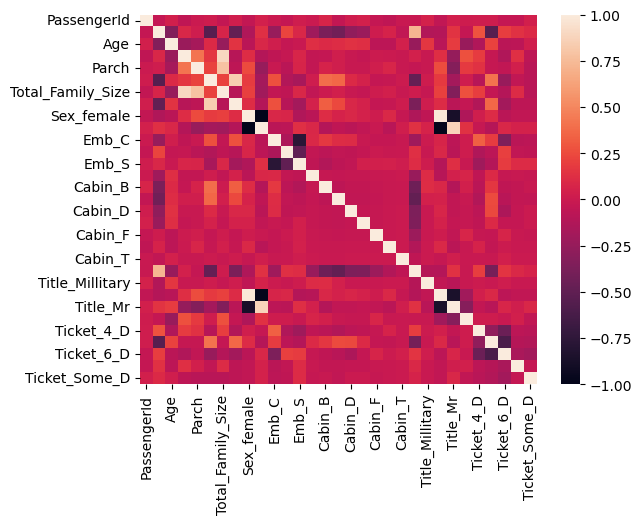

In [34]:
sns.heatmap(X.corr())

In [35]:
df_test = df_test['PassengerId']
df_test = df_full.merge(df_test, on='PassengerId', how='inner')

In [32]:
# Test Feature selection
test_X = df_test

# Predictions
test_predictions = model.predict(test_X)

In [33]:
df_submission = pd.concat([df_test['PassengerId'], pd.Series(test_predictions)], axis=1)

In [35]:
df_submission = df_submission.rename(columns={0:'Survived'})
df_submission.to_csv("titanic_results_1802202301_ada.csv", header=True, index=False)